# Student Grade Database Analysis using pyspark

In this project, we will be working with a database of course records from a (fictional) university called Syntheticus University, which was founded in Fall 2000. The university offers six undergraduate degree programs: Biology, Chemistry, Computer Science, Mathematics, and Physics. The data we will work with is assumed to have been collected immediately after the end of the Spring 2021 term.  
**Below is the list of the files and their description:**  
- **accepted.csv** - Contains a single record for any student that has been accepted into IU, whether or not they actually enrolled in courses.
 - **acc_term_id** – The term for which the student was accepted to enroll. This is a string consisting of the year followed by 'A' for Spring and 'B' for Fall. Note than not all accepted students do enroll.
 - **sid** – Student ID Number. Represented as an integer.
 - **first_name** – A string representing the student's first name.
 - **last_name** – A string representing the student's last name.
 - **major** – A string representing the student's major. ('BIO', 'CHM', 'CSC', 'MTH', or 'PHY')
- **alumni.csv** – Contains a column of sid numbers for students who have graduated from SU.
- **expelled.csv** – Contains a column of sid numbers for students who have been expelled from SU.
- **unretained.csv** – Contains a column of sid numbers for students who have transferred from SU.
- **faculty.csv** – Contains information for every faculty member who ever has taught at SU.
 - **fid** – Faculty ID Number. Represented as an integer.
 - **first_name** – A string representing the faculty member's first name.
 - **last_name** – A string representing the faculty member's last name.
 - **dept** – The dept the faculty member teaches in. ('BIO', 'CHM', 'CSC', 'MTH', 'PHY', or 'GEN')
- **courses.csv** – Contains information for all courses offered by IU.
 - **dept** – The dept that the course is offered in. ('BIO', 'CHM', 'CSC', 'MTH', 'PHY', or 'GEN')
 - **course** – This is a string containing the prefix and number of the course.
 - **prereq** – A string indicating the prerequisite for the course.
 - **credits** – An integer representing the number of credit hours for the course.
- **grades.csv** – This file contains grade records. Each record represents a grade given to a particular student in a particular course. There is one record for every grade that has every been assigned in a class at SU. This is the largest file in the database.
 - **term_id** – The term during which the grade was earned. This is a string consisting of the year followed by 'A' for Spring and 'B' for Fall.
 - **course** – A string representing the prefix and number of the course.
 - **sid** – An integer representing the SID for the student earning the grade.
 - **fid** – An integer representing the Faculty ID number for the course instructor.
 - **grade** – A string representing the letter grade that was assigned. ('A', 'B', 'C', 'D', or 'F')
 
**Please take note the following comments relating to this dataset.**
- Not all accepted students actually attend the university. If an accepted student did enroll in courses, then they will have at least one grade record in the **grades.csv** file.
- We assume that students are not able to withdraw from courses or receive incomplete grades.
- There are only three possible outcomes for a student who enrolls at the university: They graduate, they decide to leave the university (and are thus unretained), or they are expelled.
- For simplicity, we assume that students do not double major, and that no student changes their major.
- The convention we have adopted of using **A** to denote Spring terms and **B** to denote Fall terms is used simply to ensure that the terms appear in the correct chronological order when sorted.

## Part A: Set up Environment
We will start by importing the required tools for the analysis.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col , expr

spark = SparkSession.builder.getOrCreate()

## Part B: Load the Data
Here, data is imported into Spark DataFrame for the analysis.

Import the data into Spark DataFrame

In [0]:
accepted = ( 
  spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('acc_term_id STRING, sid INTEGER, first_name STRING, last_name STRING, major STRING')
    .csv('/FileStore/tables/univ/accepted.csv')
              )

alumni =(
  spark.read
    .option('delimiter' , ',')
    .option('header', True)
    .schema('sid INTEGER')
    .csv('/FileStore/tables/univ/alumni.csv')
          )

courses = (
  spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('dept STRING, course STRING, prereq STRING, credits INTEGER')
    .csv('/FileStore/tables/univ/courses.csv')
            )

expelled = (
  spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('sid INTEGER')
    .csv('/FileStore/tables/univ/expelled.csv')
              )

faculty = (
  spark.read
       .csv('/FileStore/tables/univ/faculty.csv', header ='true', schema = 'fid INTEGER, first_name STRING, last_name STRING, dept STRING')
            )


grades = (
  spark.read
       .csv('/FileStore/tables/univ/grades.csv', header ='true', schema = 'term_id STRING, course STRING, sid INTEGER, fid INTEGER, grade STRING')
            )

unretained = (
  spark.read
       .csv('/FileStore/tables/univ/unretained.csv', header ='true', schema = 'sid INTEGER')
            )

Let's have a preview of the size of the data by printing the number of records of each of the uploaded DataFrames.

In [0]:
print(f'The number of records in accepted is {accepted.count()}.')
print(f'The number of records in alumni is {alumni.count()}.')
print(f'The number of records in courses is {courses.count()}.')
print(f'The number of records in expelled is {expelled.count()}.')
print(f'The number of records in faculty is {faculty.count()}.')
print(f'The number of records in grades is {grades.count()}.')
print(f'The number of records in unretained is {unretained.count()}.')

The number of records in accepted is 12207.
The number of records in alumni is 4920.
The number of records in courses is 119.
The number of records in expelled is 403.
The number of records in faculty is 330.
The number of records in grades is 285137.
The number of records in unretained is 2289.

## Part C: Student Count by Status
Here, we will count the number of students in each of the groups: students who have been accepted, students who actually enrolled in courses, current students, all former students, alumni, unretained students, and students who were expelled.

Let's start by creating new DataFrames to store student information for students in various categories.

In [0]:
enrolled = (
  accepted
    .join(other = grades, on = 'sid' , how = 'semi' )
            )

current = (
  enrolled
    .join(other = alumni, on= 'sid' , how= 'anti')
    .join(other = unretained, on = 'sid', how = 'anti')
    .join(other = expelled, on = 'sid', how = 'anti')

            )
former = (
  enrolled
    .join(other = current, on = 'sid', how = 'anti') 
          )

print(f'Number of accepted students:   {accepted.count()}')
print(f'Number of enrolled students:   {enrolled.count()}')
print(f'Number of current students:    {current.count()}')
print(f'Number of former students:     {former.count()}')
print(f'Number of unretained students: {unretained.count()}')
print(f'Number of expelled students:   {expelled.count()}')
print(f'Number of alumni:              {alumni.count()}')

Number of accepted students: 12207
Number of enrolled students: 9667
Number of current students: 2055
Number of former students: 7612
Number of unretained students: 2289
Number of expelled students: 403
Number of alumni: 4920

## Part D: Distribution of Students by Major
Here, we will calculate the number of students currently in each major, as well as the proportion of the overall number of students in each major.

In [0]:
N = current.count()

(
  current
    .groupBy('major')
    .agg(
      expr('COUNT(major) AS n_students'),
      expr(f'ROUND(COUNT(*)/{N}, 4) as prop')
          )
    .sort('prop', ascending = False)
    .show()
      )

+-----+----------+------+
major|n_students| prop|
+-----+----------+------+
 BIO| 615|0.2993|
 CSC| 508|0.2472|
 CHM| 405|0.1971|
 MTH| 320|0.1557|
 PHY| 207|0.1007|
+-----+----------+------+

##Part E: Course Enrollments by Department
Here, we are calculating the number of students enrolled in courses offered by each department during the Spring 2021 term.

In [0]:
sp21_enr = grades.filter(expr('term_id =="2021A"')).count()

(
  grades
    .filter(expr('term_id =="2021A"'))
    .join(other= courses, on= 'course' , how = 'inner')
    .groupBy('dept')
    .agg(
      expr('COUNT(*) AS n_students'),
      expr(f'ROUND(COUNT(*)/{sp21_enr}, 4) as prop')
          )
    .sort('prop', ascending = False)
    .show()
      )

+----+----------+------+
dept|n_students| prop|
+----+----------+------+
 GEN| 5142|0.4198|
 BIO| 1786|0.1458|
 MTH| 1517|0.1238|
 CHM| 1512|0.1234|
 CSC| 1479|0.1207|
 PHY| 814|0.0664|
+----+----------+------+

## Part F: Graduation Rates by Major
In this part, we are calculating the graduation rates for each major.

Group and count the former students by major.

In [0]:
former_by_major= (
  former.groupBy('major')
        .agg(expr('COUNT(major) AS n_former'))
        .sort('major')
                  )
 
former_by_major.show()

+-----+--------+
major|n_former|
+-----+--------+
 BIO| 2243|
 CHM| 1527|
 CSC| 1940|
 MTH| 1139|
 PHY| 763|
+-----+--------+

Determine the number of alumni by major.

In [0]:
alumni_by_major = (
  former.join(other= alumni, on= 'sid' , how= 'semi')
        .groupBy('major')
        .agg(expr('COUNT(*) AS n_alumni'))
        .sort('major')
                )

alumni_by_major.show()

+-----+--------+
major|n_alumni|
+-----+--------+
 BIO| 1485|
 CHM| 1017|
 CSC| 1231|
 MTH| 723|
 PHY| 464|
+-----+--------+

Determine the graduation rates

In [0]:
(
  former_by_major
  .join(other = alumni_by_major, on='major' , how = 'inner')
  .select('*', 
          expr('ROUND(n_alumni/n_former, 4) as grad_rate')
          )
  .sort('major')
  .show()
)

+-----+--------+--------+---------+
major|n_former|n_alumni|grad_rate|
+-----+--------+--------+---------+
 BIO| 2243| 1485| 0.6621|
 CHM| 1527| 1017| 0.666|
 CSC| 1940| 1231| 0.6345|
 MTH| 1139| 723| 0.6348|
 PHY| 763| 464| 0.6081|
+-----+--------+--------+---------+

##Part G: Number of Terms Required for Graduation
Now, we are calculating the frequency distribution for the number of terms that alumni required for graduation.

Find a frequency distribution for the number of terms that alumni required for graduation.

In [0]:
(
  grades
       .join(other= alumni, on='sid' , how= 'semi')
       .groupBy('sid')
       .agg(
             expr('COUNT(DISTINCT(term_id)) AS n_terms')
             )
        .groupBy('n_terms')
        .agg(
          expr('COUNT(*) AS n_alumni')
              )
       .sort('n_terms')
       .show()
          )

+-------+--------+
n_terms|n_alumni|
+-------+--------+
 7| 200|
 8| 3045|
 9| 1203|
 10| 241|
 11| 121|
 12| 46|
 13| 32|
 14| 14|
 15| 7|
 16| 7|
 17| 2|
 18| 1|
 25| 1|
+-------+--------+

## Part H: Current Student GPA
In this section, GPA of each current student is calculated and analyzed.

Create a Python function that converts letter grades and register the UDF

In [0]:
def rank_grades(grade):
  if grade=='A':
    return 4
  elif grade == 'B':
    return 3
  elif grade == 'C':
    return 2
  elif grade == 'D':
    return 1
  else:
    return 0

spark.udf.register('rank_grades', rank_grades)       # Register the function as new spark UDF

Out[11]: <function __main__.rank_grades(grade)>

Calculate the GPA of each student currently enrolled.

In [0]:
current_gpa = (
           grades
               .join(other = courses, on = 'course', how = 'inner')
               .select('*', 
                         expr('rank_grades(grade) AS num_grade')
                         )
              .select('*',
                        expr('credits*num_grade AS gp')
                        )
              .groupBy('sid')
              .agg(
                    expr('ROUND(SUM(gp) / SUM (credits), 2) AS gpa')
                    )
              .join(other= current, on ='sid', how = 'inner')
              .select('sid', 'first_name', 'last_name', 'major', 'gpa')
              .sort('gpa')
              )
current_gpa.show(10)

+------+----------+---------+-----+----+
 sid|first_name|last_name|major| gpa|
+------+----------+---------+-----+----+
111582| Amy|Alexander| CHM|0.29|
111316| Harold| Mitchell| BIO|0.45|
111120| Lawrence| Sullivan| BIO|0.54|
111084| Emma| Ortiz| PHY|0.57|
111008| Wayne| Coleman| CSC| 0.6|
111947| Peter| Crawford| CSC| 0.6|
112082| Barbara| Thompson| PHY| 0.6|
111250| Margaret| Butler| PHY|0.62|
111909| Christine| Gomez| BIO|0.65|
111258| Alice| Butler| BIO|0.66|
+------+----------+---------+-----+----+
only showing top 10 rows

Calculate and display a count of the number of current students with 4.0 GPAs

In [0]:
current_gpa.filter(expr('gpa == 4.0')).count()

Out[13]: 95

Create a histogram displaying the distribution of GPAs for current students.

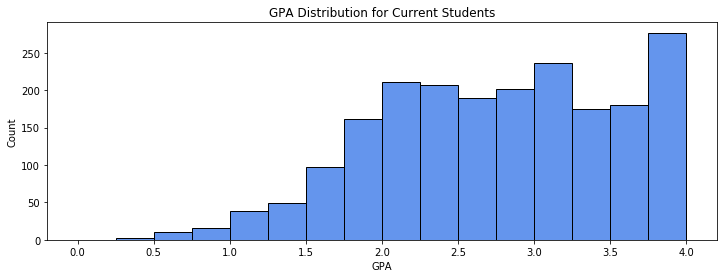

In [0]:
plt.figure(figsize=[12,4])
plt.hist(current_gpa.toPandas().gpa, color = 'cornflowerblue', edgecolor='black', bins = np.arange(0, 4.25, 0.25))
plt.title('GPA Distribution for Current Students')
plt.xlabel('GPA')
plt.ylabel('Count')
plt.show()

## Part I: Grade Distribution by Instructor
Now, we are calculating the proportion of A, B, C, D, and F grades given out by each faculty member.

Determine the distribution of grades awarded by each faculty.

In [0]:
faculty_grade_dist =(
grades
  .groupBy('fid')
  .agg(
        expr('COUNT(*) AS N'),
        expr('SUM(CASE WHEN grade == "A" THEN 1 ELSE 0 END) AS COUNTA'),
        expr('SUM(CASE WHEN grade == "B" THEN 1 ELSE 0 END) AS COUNTB'),
        expr('SUM(CASE WHEN grade == "C" THEN 1 ELSE 0 END) AS COUNTC'),
        expr('SUM(CASE WHEN grade == "D" THEN 1 ELSE 0 END) AS COUNTD'),
        expr('SUM(CASE WHEN grade == "F" THEN 1 ELSE 0 END) AS COUNTF')
          )
  .join(other = faculty , on= 'fid' , how= 'inner')
  .select(
    'fid', 'first_name', 'last_name', 'dept', 'N',
        expr('ROUND(COUNTA/N, 2) as propA'),
        expr('ROUND(COUNTB/N, 2) as propB'),
        expr('ROUND(COUNTC/N, 2) as propC'),
        expr('ROUND(COUNTD/N, 2) as propD'),
        expr('ROUND(COUNTF/N, 2) as propF')
           )
)

faculty_grade_dist.show(5)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1088| Stephanie| Williams| MTH|1666| 0.17| 0.32| 0.36| 0.13| 0.01|
1238| Willie| Black| BIO| 682| 0.48| 0.33| 0.15| 0.04| 0.01|
1829| Bobby| Wilson| GEN| 640| 0.13| 0.26| 0.37| 0.2| 0.04|
1025| Patricia| Rogers| CSC|2950| 0.3| 0.33| 0.3| 0.07| 0.0|
1084| Susan| Edwards| MTH| 80| 0.14| 0.36| 0.38| 0.11| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 5 rows

Show 10 results among the faculties who has issued at least 100 grades and sort the result by proportion of grade A.

In [0]:
(
  faculty_grade_dist
    .filter(expr('N>=100'))
    .sort('propA')
    .show(10)
  )

+----+----------+---------+----+---+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
1628| Rebecca| Stewart| GEN|395| 0.03| 0.2| 0.37| 0.28| 0.12|
1481| Abigail| Brooks| BIO|311| 0.05| 0.23| 0.37| 0.28| 0.08|
3187| Joshua| Griffin| GEN|154| 0.05| 0.24| 0.38| 0.21| 0.12|
1264| Carol| Martin| CSC|302| 0.07| 0.22| 0.34| 0.25| 0.13|
1039| Joan| Lee| BIO|147| 0.07| 0.24| 0.31| 0.33| 0.05|
1479| Karen| Simmons| GEN|310| 0.08| 0.31| 0.3| 0.21| 0.1|
1212| Michael| Martinez| MTH|775| 0.09| 0.23| 0.31| 0.27| 0.11|
1462| Ralph| Perez| BIO|195| 0.09| 0.21| 0.39| 0.23| 0.09|
1591| Amanda| Mitchell| CHM|395| 0.09| 0.29| 0.35| 0.18| 0.08|
2925| Cynthia| Lewis| GEN|302| 0.09| 0.22| 0.35| 0.25| 0.09|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
only showing top 10 rows

Show the top 10 faculties who issued highest number of grade A and also has issued a least 100 grades.

In [0]:
(
  faculty_grade_dist
    .filter(expr('N>=100'))
    .sort('propA', ascending = False)
    .show(10)
  )

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1092| Hannah| Morgan| GEN|1953| 0.59| 0.3| 0.09| 0.01| 0.0|
1262| Sara| Hunter| GEN|2266| 0.57| 0.28| 0.12| 0.02| 0.0|
1094| Judy|Patterson| GEN|1904| 0.55| 0.32| 0.12| 0.02| 0.0|
1548| Donald| Gibson| GEN|1478| 0.55| 0.27| 0.14| 0.03| 0.01|
1484| Billy| Cooper| BIO| 434| 0.54| 0.33| 0.09| 0.04| 0.01|
1328| David| Parker| GEN|1543| 0.53| 0.28| 0.14| 0.04| 0.01|
1058| John| Simpson| GEN|2729| 0.53| 0.33| 0.12| 0.02| 0.0|
1038| Theresa| Stevens| CHM| 233| 0.52| 0.31| 0.15| 0.02| 0.01|
1291| Joyce| Butler| GEN|2212| 0.51| 0.31| 0.14| 0.03| 0.01|
1305| Betty| Stewart| GEN|2081| 0.51| 0.31| 0.14| 0.04| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 10 rows

##Part J: First Term GPA
In this section, we are calculating the first-term GPA for each student who has enrolled in classes.

Calculate the first-term GPA for each student who has enrolled in classes.

In [0]:
first_term_gpa = (
  grades.join(other = accepted, on = 'sid', how ='inner')
        .filter(expr('term_id == acc_term_id'))
        .join(other = courses, on = 'course', how = 'inner')
        .select('*', expr('rank_grades(grade) AS num_grade'))
        .select('*', expr('credits*num_grade AS gp'))
        .groupBy('sid')
        .agg(
            expr('ROUND(SUM(gp) / SUM (credits), 2) AS first_term_gpa')
               )
          )
first_term_gpa.show(5)


+------+--------------+
 sid|first_term_gpa|
+------+--------------+
106724| 2.0|
107032| 4.0|
107536| 1.65|
108221| 2.82|
108460| 2.2|
+------+--------------+
only showing top 5 rows

## Part K: Graduation Rates and First Term GPA
Here, we are calculating the graduation rates for students whose first term GPA falls into each of four different grade ranges.

Create and register the python function.

In [0]:
def gpa_bin(gpa):
  bins = ['[0,1)', '[1,2)', '[2,3)', '[3,4]']
  if gpa < 4.0: 
    return bins[int(gpa)]
  else:
    return bins[3]

spark.udf.register('gpa_bin', gpa_bin)

Out[19]: <function __main__.gpa_bin(gpa)>

Calculate the number of alumni whose first-term GPA falls into different GPA bin.

In [0]:
alumni_ft_gpa =(
  first_term_gpa
      .join(other=alumni , on='sid' , how='semi')
      .select('*',expr('gpa_bin(first_term_gpa) AS gpa_bin'))
      .groupBy('gpa_bin')
      .agg(
            expr('COUNT(*) AS n_alumni')
              )
      .sort('gpa_bin')
      )

alumni_ft_gpa.show()

+-------+--------+
gpa_bin|n_alumni|
+-------+--------+
 [0,1)| 4|
 [1,2)| 549|
 [2,3)| 1887|
 [3,4]| 2480|
+-------+--------+

Determine the number of former students whose first-term GPA falls into each bin.

In [0]:
former_ft_gpa = (
first_term_gpa
  .join(other = former, on = 'sid', how = 'semi') # Keeping record from first df that is also in second df
  .select('*',expr('gpa_bin(first_term_gpa) AS gpa_bin'))
  .groupBy('gpa_bin')
  .agg(
  expr('COUNT(*) AS n_former')
  )
  .sort('gpa_bin')
)
former_ft_gpa.show(5)

+-------+--------+
gpa_bin|n_former|
+-------+--------+
 [0,1)| 822|
 [1,2)| 1735|
 [2,3)| 2433|
 [3,4]| 2622|
+-------+--------+

Determine the graduation rates for each of the GPA bins.

In [0]:
(
  alumni_ft_gpa
  .join(other= former_ft_gpa , on='gpa_bin' , how = 'inner')
  .select('*',expr('ROUND(n_alumni/n_former, 4) AS grad_rate'))
  .sort('gpa_bin')
).show()

+-------+--------+--------+---------+
gpa_bin|n_alumni|n_former|grad_rate|
+-------+--------+--------+---------+
 [0,1)| 4| 822| 0.0049|
 [1,2)| 549| 1735| 0.3164|
 [2,3)| 1887| 2433| 0.7756|
 [3,4]| 2480| 2622| 0.9458|
+-------+--------+--------+---------+